In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2024dl/submission.csv
/kaggle/input/2024dl/train.csv
/kaggle/input/2024dl/test.csv
/kaggle/input/2024dl/DICOM/A740156/00010021
/kaggle/input/2024dl/DICOM/A481686/00010030
/kaggle/input/2024dl/DICOM/A558231/00010036
/kaggle/input/2024dl/DICOM/A608573/00010019
/kaggle/input/2024dl/DICOM/A514552/00010020
/kaggle/input/2024dl/DICOM/A672570/00010023
/kaggle/input/2024dl/DICOM/A340115/00010036
/kaggle/input/2024dl/DICOM/A325875/00010019
/kaggle/input/2024dl/DICOM/A596084/00010021
/kaggle/input/2024dl/DICOM/A520919/00010031
/kaggle/input/2024dl/DICOM/A718487/00010023
/kaggle/input/2024dl/DICOM/A681216/00010023
/kaggle/input/2024dl/DICOM/A159139/00010031
/kaggle/input/2024dl/DICOM/A741758/00010017
/kaggle/input/2024dl/DICOM/A15422/00010024
/kaggle/input/2024dl/DICOM/A29870/00010019
/kaggle/input/2024dl/DICOM/X388459/00010022
/kaggle/input/2024dl/DICOM/A521149/00010022
/kaggle/input/2024dl/DICOM/A658847/00010022
/kaggle/input/2024dl/DICOM/A570701/00010019
/kaggle/input/2024dl/DICO

In [2]:
!pip install torchsummary

In [3]:
import pydicom
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [6]:
class config:
    
    root = "/kaggle/input/2024dl"
    batch_size = 16
    lr = 1e-4
    epochs = 100
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 3
    
print('device:', config.device)

device: cuda


In [7]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 161
Number of testing samples: 41


In [8]:
train_data['Stage'].value_counts().sort_index()

Stage
1    44
2    42
3    75
Name: count, dtype: int64

In [9]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

In [11]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train() 
    
    train_loss = .0
    predictions, ground_truths = [], []
    
    for images, ages, genders, labels in train_loader:
        images = images.to(device = device, dtype = torch.float)
        ages = ages.to(device = device, dtype = torch.float)
        genders = genders.to(device = device, dtype = torch.float)
        labels = labels.to(device = device, dtype = torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)
        
        # Pytorch 中的分類損失函數（如 CrossEntropyLoss）期望 label 為 0 開始的整數。
        labels = torch.sub(labels, 1) # labels 1, 2, 3 -> 0, 1, 2
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim = 1)

        predictions.append(preds)
        ground_truths.append(labels)
    
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1, 100*train_misclass

In [12]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []

    with torch.no_grad():
        for images, ages, genders, labels in valid_loader:
            images = images.to(device = device, dtype = torch.float)
            ages = ages.to(device = device, dtype = torch.float)
            genders = genders.to(device = device, dtype = torch.float)
            labels = labels.to(device = device, dtype = torch.long)

            logits = model(images, ages, genders)
            labels = torch.sub(labels, 1)
            loss = criterion(logits, labels)
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim = 1)
            predictions.append(preds)
            ground_truths.append(labels)

       
        valid_loss /= len(valid_loader)

        
        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)

        
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    return valid_loss, 100*valid_acc, 100*valid_f1, 100*valid_misclass

In [13]:
class Normalization(object):
    
    def __call__(self, image): # 定義有image之後要進行的資料處理
        changed_image = (image - image.min())/(image.max() - image.min())
        return changed_image

def build_transform_ViT(is_train):
    """
    Create a data transformation pipeline for image preprocessing in deep learning tasks.
    """
    t = []
    if is_train:
        # ViT 原本的 input 要求224x224，但我們的影像只有128x128，
        # 為了配合這次50x50，我就把 224/4=56，當作 model 的 input
        # 所以跟原本的 build_transform 有所不同，這裡就改成 build_transform_ViT。
        t.append(v2.CenterCrop(size = (56, 56)))
        t.append(Normalization())
        return v2.Compose(t)
    
    t.append(v2.CenterCrop(size = (56, 56)))
    t.append(Normalization())
    return v2.Compose(t)

In [14]:
class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode=None, transforms=None):
        self.df = df
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, x):
        age = torch.tensor(self.df.iloc[x, 1])  # 年齡
        gender = torch.tensor(self.df.iloc[x, 2])  # 性別
        index = torch.tensor(self.df.iloc[x, 4])  # 起始張數

        # 影像前處理
        image = pydicom.dcmread(config.root + self.df.iloc[x, 3]).pixel_array
        image = torch.tensor(image.astype(np.float32))
        image = image[index-1:index+2, :, :]

        if self.mode == "train":
            label = torch.tensor(self.df.iloc[x, 5])  # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label

        elif self.mode == "valid":
            label = torch.tensor(self.df.iloc[x, 5])  # 標籤
            if self.transforms: image = self.transforms(image)
            return image, age, gender, label

        elif self.mode == "test":
            if self.transforms: image = self.transforms(image)
            return image, age, gender

In [ ]:
from timm.models.vision_transformer import VisionTransformer, PatchEmbed

class VisionTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformerCustom, self).__init__()
        
        self.model = VisionTransformer(
            img_size=56,                # 影像大小
            patch_size=8,               # 一個 patch 大小
            in_chans=3,                 # input channels 大小
            embed_dim=96,               #  patch 經過展平再 linear 的維度
            embed_layer=PatchEmbed,     # 使用 PatchEmbed 完成上述的動作
            norm_layer=nn.LayerNorm,    # 使用 LayerNorm 來 norm
            depth=12,                   # 使用 12個 Blocks(Encoders)
            num_classes=num_classes     # 輸出的維度
        )
        
        self.model.head = nn.Identity() # 將最後的分類弄成 Identity()

        self.classifier = nn.Sequential(
            nn.Linear(96 + 2, num_classes)  # 把 age, gender 放進其中
        )
        

    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim = 1)
        x = self.classifier(x)
        return x

In [ ]:
# TODO_6: 建立 VIT
model = VisionTransformer(
            img_size=56,                # 影像大小
            patch_size=8,               # 一個 patch 大小
            in_chans=3,                 # input channels 大小
            embed_dim=96,               #  patch 經過展平再 linear 的維度
            embed_layer=PatchEmbed,     # 使用 PatchEmbed 完成上述的動作
            norm_layer=nn.LayerNorm,    # 使用 LayerNorm 來 norm
            depth=12,                   # 使用 12個 Blocks(Encoders)
            num_classes=config.num_classes     # 輸出的維度
        )
model.to(config.device)
summary(model, (3, 56, 56))
del model

In [20]:
from timm.models.swin_transformer import SwinTransformer, PatchEmbed
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

class SwinTransformerCustom(nn.Module):
    def __init__(self, num_classes):
        super(SwinTransformerCustom, self).__init__()

        self.model = SwinTransformer(
            img_size=56,
            patch_size=4,
            in_chans=3,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            norm_layer=nn.LayerNorm,
            num_classes=num_classes
        )

        self.model.head.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(768 + 2, num_classes)  # 把 age, gender 放進其中
        )
        
    def forward(self, x, age, gender):
        x = self.model(x)
        x = torch.cat([x, age.view(-1, 1), gender.view(-1, 1)], dim=1)
        x = self.classifier(x)
        return x

In [21]:
model = SwinTransformerCustom(num_classes=3)
model.to(config.device)
print(model)

SwinTransformerCustom(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, 

Initializing model...
Epoch[1/100], Train Loss: 2.4079, Train Acc: 27.34%, Train F1: 16.06% | Valid Loss: 1.5286, Valid Acc: 42.42%, Valid F1: 31.57%, Valid Misclass: 57.58% | LR: 0.000004
Epoch[2/100], Train Loss: 1.2327, Train Acc: 42.97%, Train F1: 25.10% | Valid Loss: 1.2848, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[3/100], Train Loss: 1.2487, Train Acc: 43.75%, Train F1: 29.79% | Valid Loss: 1.2464, Valid Acc: 30.30%, Valid F1: 21.44%, Valid Misclass: 69.70% | LR: 0.000004
Epoch[4/100], Train Loss: 1.3248, Train Acc: 35.94%, Train F1: 25.91% | Valid Loss: 1.2544, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[5/100], Train Loss: 1.2251, Train Acc: 47.66%, Train F1: 23.30% | Valid Loss: 1.2015, Valid Acc: 45.45%, Valid F1: 20.83%, Valid Misclass: 54.55% | LR: 0.000004
Epoch[6/100], Train Loss: 1.1252, Train Acc: 47.66%, Train F1: 28.43% | Valid Loss: 1.1560, Valid Acc: 48.48%, Valid F1: 30.56%, Valid Misclass

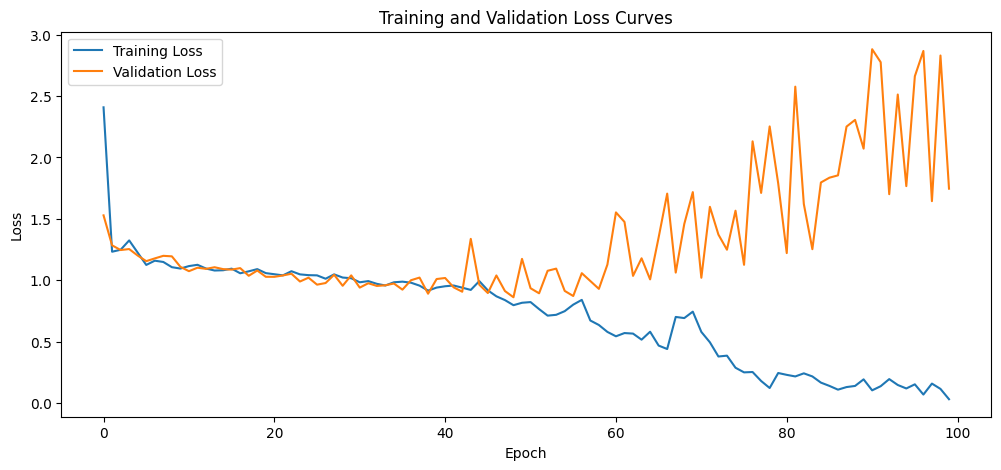

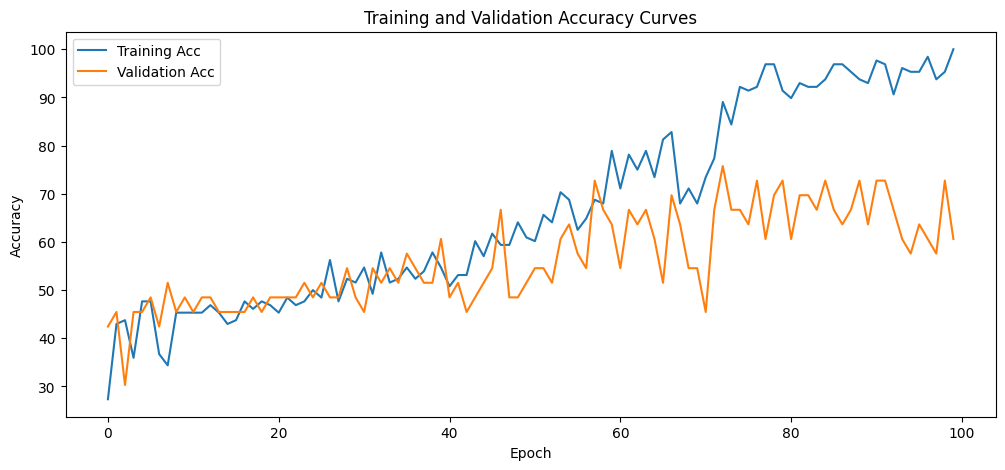

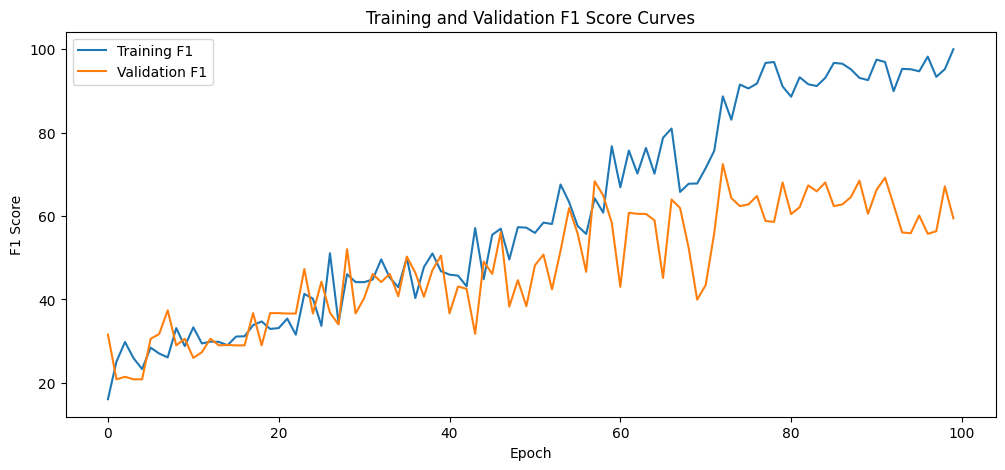

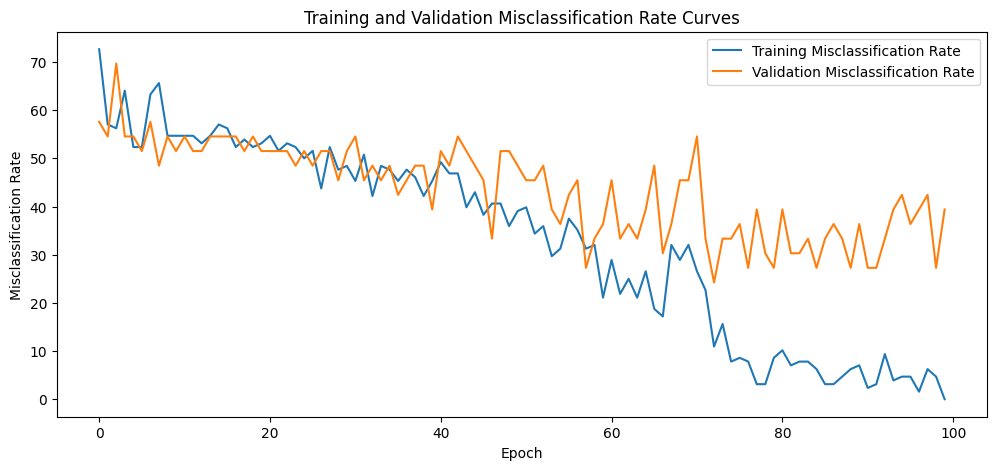

In [22]:
def main():
    seed_everything(config.seed)
    
    # train dataframe
    train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
    
    # TODO_4: split the training dataset，通常是 8:2，但可以嘗試其他的分法，e.g. 7:3。
    # split training & validation dataset 
    train_dataset, val_dataset = train_test_split(train_data, train_size=0.8, test_size=0.2, random_state=config.seed)
    
    # 注意這裡的 build_transform 要更正為 build_transform_ViT 
    train_dataset = ParkinsonsDataset(train_dataset, transforms=build_transform_ViT(True), mode="train")
    val_dataset = ParkinsonsDataset(val_dataset, transforms=build_transform_ViT(False), mode="valid")
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    # settings
    print("Initializing model...")
    
    model = SwinTransformerCustom(config.num_classes) 
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad] 
    
    # TODO_5: 調整適當的 optimizer、scheduler。
    optimizer = optim.Adam(parameters, lr=config.lr, weight_decay=config.weight_decay) 
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        max_lr=config.lr,
        anneal_strategy='cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(model, val_loader, criterion, config.device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%, Valid Misclass: {valid_misclass:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
        
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

    best_ckpt = torch.load("checkpoint.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    plt.figure(figsize=(12, 5))
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    # TODO_6: 畫出 train 跟 valid 的 Misclassification Rate 圖。
    plt.figure(figsize=(12, 5))
    plt.plot(range(config.epochs), history["train"]["misclass"], label='Training Misclassification Rate')
    plt.plot(range(config.epochs), history["valid"]["misclass"], label='Validation Misclassification Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Misclassification Rate')
    plt.legend()
    plt.title('Training and Validation Misclassification Rate Curves')
    plt.show()

if __name__ == "__main__":
    main()


In [23]:
def testing(model, test_loader, device):
    model.eval()  # 設置模型為推理模式，關閉 dropout 和 batch normalization
    preds = []
    
    # 禁用自動梯度計算，因為在測試過程中不需要進行反向傳播
    with torch.no_grad():  
        for image, age, gender in test_loader:
            image = image.to(device=device, dtype=torch.float)  # 將圖像移動到指定設備 (如 GPU) 並轉為浮點數
            age = age.to(device)  # 將年齡移動到指定設備
            gender = gender.to(device)  # 將性別移動到指定設備
            
            # 前向傳播，獲取模型對圖像的預測
            logits = model(image, age, gender)
            
            # 通過 `torch.argmax` 選擇預測概率最大的類別作為最終預測結果
            pred = torch.argmax(logits, dim=1)
            
            # 將這個批次的預測結果添加到 preds 列表中
            preds.append(pred)

    # 將所有批次的預測結果拼接成一個長張量
    preds = torch.cat(preds)

    # TODO_8: 因為模型輸出的 preds 為 0, 1, 2，因此我們將它們調整為 1, 2, 3。
    # 這是因為訓練集中的類別標籤範圍為 1, 2, 3，而模型輸出的類別為從 0 開始的數字。
    preds = preds + 1
    
    return preds

In [26]:
seed_everything(config.seed)

# 讀取測試數據
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

# TODO_9: 填寫 test_dataset、test_loader、model，記得 test_loader 的 shuffle = False。

# 創建測試數據集
test_dataset = ParkinsonsDataset(test_data, transforms=build_transform_ViT(False), mode="test")

# 創建測試數據加載器
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# 加載預訓練模型
model = SwinTransformerCustom(num_classes=config.num_classes)

# 將模型移動到指定設備 (CPU 或 GPU)
model.to(config.device)

# 加載保存的最佳模型檢查點
best_ckpt = torch.load(f"checkpoint.pth")

# 加載模型權重
model.load_state_dict(best_ckpt["model"])

# 使用測試數據進行推理
preds = testing(model, test_loader, config.device)

In [27]:
df = pd.read_csv(os.path.join(config.root, 'submission.csv'))
df = pd.DataFrame(df)
df['Stage'] = preds.cpu().numpy() # 將 preds 從 GPU 轉移到 CPU 並轉換為 NumPy 陣列
df.to_csv('SwinVit.csv',index = False, header = True)